This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False
    country_num = 10

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 28.4 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

In [ ]:
countries = train['country'].value_counts()
major_countries = countries[countries > CFG.country_num].index
major_countries

Index(['US', 'TR', 'ID', 'JP', 'TH', 'RU', 'BR', 'MY', 'BE', 'GB',
       ...
       'CM', 'AG', 'MW', 'VC', 'VA', 'RW', 'DM', 'CV', 'SX', 'CD'],
      dtype='object', length=176)

In [ ]:
mean_latlon = train[train['country'].isin(major_countries)].groupby('country')[['latitude', 'longitude']].mean().apply(lambda x: tuple(x), axis = 1).to_dict()
mean_latlon

{'AD': (42.545859185636466, 1.5623949169263895),
 'AE': (25.031196156825867, 55.125843416026626),
 'AF': (33.83802625734884, 66.24355789971725),
 'AG': (17.064483743894495, -61.8103130873108),
 'AL': (41.16438043034689, 19.412328749941274),
 'AM': (40.226330254579786, 44.639090877452354),
 'AO': (-8.889374849019317, 13.202976589291133),
 'AQ': (-69.60762211178053, -13.85584018293251),
 'AR': (-34.3017973185889, -59.675176940818325),
 'AT': (47.82784149912836, 14.668674401181589),
 'AU': (-33.60605387334255, 145.81505022396252),
 'AW': (12.538799105310463, -70.0247308418892),
 'AX': (59.189586941545805, 18.925737862902142),
 'AZ': (40.3754732198509, 49.74492239537704),
 'BA': (43.94847201899628, 18.204256543029196),
 'BB': (13.108549846295455, -59.59389100581457),
 'BD': (23.832095040888664, 89.78014903512299),
 'BE': (50.98628567649715, 4.058717644388699),
 'BG': (42.641392575674466, 24.688713330227394),
 'BH': (26.24331108929355, 50.43609293011559),
 'BL': (17.904371494236624, -62.841

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def correct_country(latlon):
    min_distance = float('inf')
    min_country = None
    for country in major_countries:
        distance = haversine(latlon, mean_latlon[country])
        if distance < min_distance:
            min_distance = distance
            min_country = country
    return min_country
train['new_country'] = train[['latitude', 'longitude']].apply(correct_country, axis = 1)
test['new_country'] = test[['latitude', 'longitude']].apply(correct_country, axis = 1)
print('Concordance rate: ' + str((train['country'] == train['new_country']).mean()))
train.head()

Concordance rate: 0.7032521610239443


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,new_country
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,BE
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,BR
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,TH
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,TR
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,ES


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("new_country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories
0,E_0014dae22ccd6b,shôko restaurant,41.385287,2.197004,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ES,nan,...,E_0014dae22ccd6b,shôko restaurant,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ad,nan,nan,japanese restaurants


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories,target
363,E_1c42297fda9e48,beverage station,44.752732,-1.086829,nan,nan,nan,33510,FR,nan,...,the beverage station,nan,nan,nan,33510,ad,nan,nan,fast food restaurants,1
373,E_1d31342d2e5805,estación de servicio cepsa,43.284564,-2.265653,barrio narrondo,zumaia,gipuzkoa,20750,ES,https://cercadeti.cepsa.es/6114-estacion-de-se...,...,estación de servicio cepsa,barrio narrondo,zumaia,gipuzkoa,20750,ad,https://cercadeti.cepsa.es/530-estacion-de-ser...,+34943861082,nan,1
642,E_34e1bc94cd94d3,rent a car saint jean de luz,43.406270,-1.616368,zi de jalday,saint jean de luz,aquitaine-limousin-poitou-charentes,64500,FR,https://www.rentacar.fr/agences/391-saint-jean...,...,rent a car saint jean de luz,zi de jalday,saint jean de luz,nan,64500,ad,https://www.rentacar.fr/agences/391-saint-jean...,+33559507060,rental car locations,1
719,E_3bdf0c22354e57,taverna ongi etorriak,41.346620,1.696817,carrer sant bernat,vilafranca del penedes,barcelona,08720,ES,nan,...,ongi etorriak,"c. de sant bernat, 4",vilafranca del penedes,barcelona,08720,ad,nan,938904354,tapas restaurants,1
730,E_3cb8475424e07f,obaibi,43.607900,1.394600,36/54 rte de bayonne,toulouse,france,31 000,FR,nan,...,okaidi-obaibi,36/54 rte de bayonne,toulouse,france,31 000,ad,nan,nan,"kids stores, arcades",1


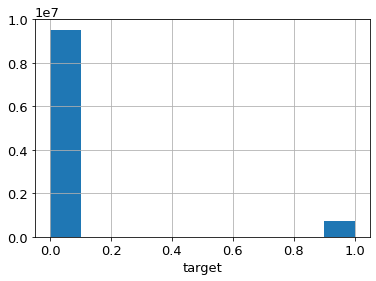

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8929518335714638


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 14.3 MB/s 
     |████████████████████████████████| 1.8 MB 34.8 MB/s 
     |████████████████████████████████| 103 kB 64.2 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['new_country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('new_country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
50768,E_02ef4d9ef8aa33,beach,17.085518,-61.893896,hermitage bay,st. john's,parish of saint john,nan,AG,nan,...,3,0.166667,15,0.30112,2,7,17,0.882353,0.117647,0.285714


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
4,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,ID,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'new_country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['new_country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_new_country_gesh', 'near_new_country_jaro', 'near_new_country_lcs', 'near_new_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categor

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id"]]
test = test[features + ["id", "near_id"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10250452 entries, 0 to 10250451
Data columns (total 59 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0856926
[100]	valid_0's binary_logloss: 0.0825799
[150]	valid_0's binary_logloss: 0.0808971
[200]	valid_0's binary_logloss: 0.0799269
[250]	valid_0's binary_logloss: 0.0790991
[300]	valid_0's binary_logloss: 0.0785043
[350]	valid_0's binary_logloss: 0.0779752
[400]	valid_0's binary_logloss: 0.0775243
[450]	valid_0's binary_logloss: 0.0771382
[500]	valid_0's binary_logloss: 0.0768026
[550]	valid_0's binary_logloss: 0.0765093
[600]	valid_0's binary_logloss: 0.0762668
[650]	valid_0's binary_logloss: 0.0760104
[700]	valid_0's binary_logloss: 0.0757376
[750]	valid_0's binary_logloss: 0.0754801
[800]	valid_0's binary_logloss: 0.0752896
[850]	valid_0's binary_logloss: 0.0751124
[900]	valid_0's binary_logloss: 0.0748388
[950]	valid_0's binary_logloss: 0.0746338
[1000]	valid_0's binary_logloss: 0.0744101
[1050]	valid_0's binary_logloss: 0.0742567
[1100]	valid_0's binary_logloss: 0.0740892
[1150]	valid_0's binary_logloss: 0.0739119
[1200]	valid_0's b

In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 23.7 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 210 kB 68.9 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 68.0 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 69.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=694df0546a634272044c2dd517fcb3f73a13cf998823ccd914bfb5cf9b43733c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 09:02:26,081] A new study created in memory with name: no-name-fb33bdae-3d85-4585-993b-2a30ce01f865
[I 2022-05-13 09:02:48,653] Trial 0 finished with value: 0.8267697436462047 and parameters: {'threshold': 0.4401035042002581}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.826770, precision: 0.967219, recall: 0.854500


[I 2022-05-13 09:03:10,694] Trial 1 finished with value: 0.8148143957777184 and parameters: {'threshold': 0.22429383165415573}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.814814, precision: 0.935455, recall: 0.869584


[I 2022-05-13 09:03:31,782] Trial 2 finished with value: 0.8263419688705554 and parameters: {'threshold': 0.4069157986955797}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.826342, precision: 0.963859, recall: 0.856938


[I 2022-05-13 09:03:58,030] Trial 3 finished with value: 0.7441454097723903 and parameters: {'threshold': 0.04771749003997383}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.744145, precision: 0.832806, recall: 0.884042


[I 2022-05-13 09:04:15,953] Trial 4 finished with value: 0.8157963704109373 and parameters: {'threshold': 0.7394578755103869}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.815796, precision: 0.988059, recall: 0.825718


[I 2022-05-13 09:04:35,232] Trial 5 finished with value: 0.8258042791598676 and parameters: {'threshold': 0.5568218544941271}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.825804, precision: 0.977036, recall: 0.845120


[I 2022-05-13 09:04:58,274] Trial 6 finished with value: 0.8131082517100743 and parameters: {'threshold': 0.21172491496465062}. Best is trial 0 with value: 0.8267697436462047.


CV: 0.813108, precision: 0.932378, recall: 0.870473


[I 2022-05-13 09:05:18,340] Trial 7 finished with value: 0.8268439349852645 and parameters: {'threshold': 0.4511089304504724}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.826844, precision: 0.968273, recall: 0.853674


[I 2022-05-13 09:05:40,331] Trial 8 finished with value: 0.8173432685672323 and parameters: {'threshold': 0.24594160530632714}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.817343, precision: 0.940210, recall: 0.868075


[I 2022-05-13 09:06:05,022] Trial 9 finished with value: 0.7799933119630647 and parameters: {'threshold': 0.09243033070296436}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.779993, precision: 0.881754, recall: 0.879640


[I 2022-05-13 09:06:22,047] Trial 10 finished with value: 0.8017189592194673 and parameters: {'threshold': 0.8499109564539102}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.801719, precision: 0.993252, recall: 0.807261


[I 2022-05-13 09:06:41,268] Trial 11 finished with value: 0.8256680837321639 and parameters: {'threshold': 0.5621946355371591}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.825668, precision: 0.977431, recall: 0.844641


[I 2022-05-13 09:07:01,585] Trial 12 finished with value: 0.8264702077582198 and parameters: {'threshold': 0.41382130766332254}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.826470, precision: 0.964596, recall: 0.856437


[I 2022-05-13 09:07:19,706] Trial 13 finished with value: 0.8192393272418254 and parameters: {'threshold': 0.6956692755433211}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.819239, precision: 0.985774, recall: 0.831102


[I 2022-05-13 09:07:40,772] Trial 14 finished with value: 0.8263023897462249 and parameters: {'threshold': 0.40546506568445434}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.826302, precision: 0.963700, recall: 0.857038


[I 2022-05-13 09:07:59,509] Trial 15 finished with value: 0.822213292654831 and parameters: {'threshold': 0.6472133031821192}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.822213, precision: 0.983016, recall: 0.836421


[I 2022-05-13 09:08:20,639] Trial 16 finished with value: 0.8233114766474269 and parameters: {'threshold': 0.32163358973498424}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.823311, precision: 0.953287, recall: 0.862931


[I 2022-05-13 09:08:32,860] Trial 17 finished with value: 0.7306060464813697 and parameters: {'threshold': 0.9879678577266067}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.730606, precision: 0.999354, recall: 0.731129


[I 2022-05-13 09:08:53,241] Trial 18 finished with value: 0.8268174059138683 and parameters: {'threshold': 0.4900957535689152}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.826817, precision: 0.971757, recall: 0.850658


[I 2022-05-13 09:09:12,814] Trial 19 finished with value: 0.826229056072985 and parameters: {'threshold': 0.5346925834136536}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.826229, precision: 0.975348, recall: 0.846992


[I 2022-05-13 09:09:29,877] Trial 20 finished with value: 0.8080241228046453 and parameters: {'threshold': 0.8093161278261234}. Best is trial 7 with value: 0.8268439349852645.


CV: 0.808024, precision: 0.991420, recall: 0.815112


[I 2022-05-13 09:09:49,967] Trial 21 finished with value: 0.8268554035991299 and parameters: {'threshold': 0.4536019719394673}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.826855, precision: 0.968491, recall: 0.853491


[I 2022-05-13 09:10:11,110] Trial 22 finished with value: 0.8236433689302979 and parameters: {'threshold': 0.32798472940166423}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.823643, precision: 0.954197, recall: 0.862490


[I 2022-05-13 09:10:30,911] Trial 23 finished with value: 0.8268035017863465 and parameters: {'threshold': 0.4916276703096748}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.826804, precision: 0.971882, recall: 0.850537


[I 2022-05-13 09:10:49,569] Trial 24 finished with value: 0.8229547760475077 and parameters: {'threshold': 0.6331412197060557}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.822955, precision: 0.982177, recall: 0.837878


[I 2022-05-13 09:11:10,500] Trial 25 finished with value: 0.8242135608125793 and parameters: {'threshold': 0.33898273769938836}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.824214, precision: 0.955762, recall: 0.861737


[I 2022-05-13 09:11:33,161] Trial 26 finished with value: 0.8053241269961652 and parameters: {'threshold': 0.16782052842771306}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.805324, precision: 0.919480, recall: 0.873611


[I 2022-05-13 09:11:51,901] Trial 27 finished with value: 0.8239186281852455 and parameters: {'threshold': 0.6114852221929847}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.823919, precision: 0.980785, recall: 0.840021


[I 2022-05-13 09:12:12,341] Trial 28 finished with value: 0.8268493020726809 and parameters: {'threshold': 0.480707539912597}. Best is trial 21 with value: 0.8268554035991299.


CV: 0.826849, precision: 0.970930, recall: 0.851393


[I 2022-05-13 09:12:32,238] Trial 29 finished with value: 0.826855757359968 and parameters: {'threshold': 0.4516761368182283}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826856, precision: 0.968328, recall: 0.853636


[I 2022-05-13 09:12:53,638] Trial 30 finished with value: 0.8207380725184515 and parameters: {'threshold': 0.2827968104938002}. Best is trial 29 with value: 0.826855757359968.


CV: 0.820738, precision: 0.947108, recall: 0.865591


[I 2022-05-13 09:13:13,638] Trial 31 finished with value: 0.8268453572785396 and parameters: {'threshold': 0.46058519881520604}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826845, precision: 0.969112, recall: 0.852949


[I 2022-05-13 09:13:33,562] Trial 32 finished with value: 0.8268534012551003 and parameters: {'threshold': 0.45321760935900884}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826853, precision: 0.968460, recall: 0.853517


[I 2022-05-13 09:13:54,890] Trial 33 finished with value: 0.8254922787054313 and parameters: {'threshold': 0.37234679269662824}. Best is trial 29 with value: 0.826855757359968.


CV: 0.825492, precision: 0.959976, recall: 0.859412


[I 2022-05-13 09:14:13,762] Trial 34 finished with value: 0.8249884687666936 and parameters: {'threshold': 0.5827639395099931}. Best is trial 29 with value: 0.826855757359968.


CV: 0.824988, precision: 0.978859, recall: 0.842744


[I 2022-05-13 09:14:33,364] Trial 35 finished with value: 0.8265253656703897 and parameters: {'threshold': 0.5188178042491803}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826525, precision: 0.974146, recall: 0.848309


[I 2022-05-13 09:14:53,652] Trial 36 finished with value: 0.8261040708178408 and parameters: {'threshold': 0.3947287857459488}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826104, precision: 0.962561, recall: 0.857809


[I 2022-05-13 09:15:13,661] Trial 37 finished with value: 0.82685377675251 and parameters: {'threshold': 0.45254176099710924}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826854, precision: 0.968400, recall: 0.853568


[I 2022-05-13 09:15:31,755] Trial 38 finished with value: 0.8197873194974917 and parameters: {'threshold': 0.6876069655996597}. Best is trial 29 with value: 0.826855757359968.


CV: 0.819787, precision: 0.985328, recall: 0.832022


[I 2022-05-13 09:15:55,389] Trial 39 finished with value: 0.8046466156575092 and parameters: {'threshold': 0.16459021389377176}. Best is trial 29 with value: 0.826855757359968.


CV: 0.804647, precision: 0.918360, recall: 0.873873


[I 2022-05-13 09:16:16,779] Trial 40 finished with value: 0.8203937731491664 and parameters: {'threshold': 0.2785418240709682}. Best is trial 29 with value: 0.826855757359968.


CV: 0.820394, precision: 0.946377, recall: 0.865861


[I 2022-05-13 09:16:36,955] Trial 41 finished with value: 0.8268471495270726 and parameters: {'threshold': 0.45518476937433555}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826847, precision: 0.968637, recall: 0.853359


[I 2022-05-13 09:16:56,554] Trial 42 finished with value: 0.8266975669627635 and parameters: {'threshold': 0.5053889034324653}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826698, precision: 0.973033, recall: 0.849447


[I 2022-05-13 09:17:18,684] Trial 43 finished with value: 0.8251553908751715 and parameters: {'threshold': 0.3616959487025658}. Best is trial 29 with value: 0.826855757359968.


CV: 0.825155, precision: 0.958674, recall: 0.860182


[I 2022-05-13 09:17:38,613] Trial 44 finished with value: 0.8266255256774544 and parameters: {'threshold': 0.4254125866174367}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826626, precision: 0.965771, recall: 0.855586


[I 2022-05-13 09:17:57,531] Trial 45 finished with value: 0.825595735072452 and parameters: {'threshold': 0.5640513504162049}. Best is trial 29 with value: 0.826855757359968.


CV: 0.825596, precision: 0.977560, recall: 0.844456


[I 2022-05-13 09:18:17,394] Trial 46 finished with value: 0.826851416145501 and parameters: {'threshold': 0.4592875363028838}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826851, precision: 0.969001, recall: 0.853049


[I 2022-05-13 09:18:37,528] Trial 47 finished with value: 0.8265916225882276 and parameters: {'threshold': 0.4210390692811408}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826592, precision: 0.965341, recall: 0.855914


[I 2022-05-13 09:18:56,454] Trial 48 finished with value: 0.8248245215076148 and parameters: {'threshold': 0.5871106926250506}. Best is trial 29 with value: 0.826855757359968.


CV: 0.824825, precision: 0.979142, recall: 0.842342


[I 2022-05-13 09:19:17,690] Trial 49 finished with value: 0.8207553024566132 and parameters: {'threshold': 0.2829926120566041}. Best is trial 29 with value: 0.826855757359968.


CV: 0.820755, precision: 0.947141, recall: 0.865578


[I 2022-05-13 09:19:37,549] Trial 50 finished with value: 0.8262201220131214 and parameters: {'threshold': 0.5357869473004397}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826220, precision: 0.975440, recall: 0.846906


[I 2022-05-13 09:19:57,118] Trial 51 finished with value: 0.8268125257730436 and parameters: {'threshold': 0.4871769428714597}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826813, precision: 0.971500, recall: 0.850871


[I 2022-05-13 09:20:17,119] Trial 52 finished with value: 0.8268505719685134 and parameters: {'threshold': 0.46015275708792125}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826851, precision: 0.969079, recall: 0.852982


[I 2022-05-13 09:20:38,007] Trial 53 finished with value: 0.8255834403652822 and parameters: {'threshold': 0.37513413455513117}. Best is trial 29 with value: 0.826855757359968.


CV: 0.825583, precision: 0.960304, recall: 0.859222


[I 2022-05-13 09:20:58,038] Trial 54 finished with value: 0.826766912674387 and parameters: {'threshold': 0.43822606285409144}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826767, precision: 0.967043, recall: 0.854650


[I 2022-05-13 09:21:18,155] Trial 55 finished with value: 0.826764877304246 and parameters: {'threshold': 0.4406068198813034}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826765, precision: 0.967270, recall: 0.854455


[I 2022-05-13 09:21:38,069] Trial 56 finished with value: 0.825981320746357 and parameters: {'threshold': 0.5490231817750426}. Best is trial 29 with value: 0.826855757359968.


CV: 0.825981, precision: 0.976457, recall: 0.845794


[I 2022-05-13 09:21:58,881] Trial 57 finished with value: 0.8231519024160485 and parameters: {'threshold': 0.3184656038632813}. Best is trial 29 with value: 0.826855757359968.


CV: 0.823152, precision: 0.952834, recall: 0.863157


[I 2022-05-13 09:22:17,023] Trial 58 finished with value: 0.8211052815956638 and parameters: {'threshold': 0.6669510097341277}. Best is trial 29 with value: 0.826855757359968.


CV: 0.821105, precision: 0.984172, recall: 0.834325


[I 2022-05-13 09:22:37,229] Trial 59 finished with value: 0.8261403436028409 and parameters: {'threshold': 0.3962821480589811}. Best is trial 29 with value: 0.826855757359968.


CV: 0.826140, precision: 0.962725, recall: 0.857705


[I 2022-05-13 09:22:54,537] Trial 60 finished with value: 0.8127270005115341 and parameters: {'threshold': 0.7707706395866516}. Best is trial 29 with value: 0.826855757359968.


CV: 0.812727, precision: 0.989636, recall: 0.821323


[I 2022-05-13 09:23:14,139] Trial 61 finished with value: 0.8268737293723015 and parameters: {'threshold': 0.47118619553586893}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826874, precision: 0.970102, recall: 0.852130


[I 2022-05-13 09:23:33,821] Trial 62 finished with value: 0.826849414936095 and parameters: {'threshold': 0.4608145516999366}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826849, precision: 0.969139, recall: 0.852930


[I 2022-05-13 09:23:53,995] Trial 63 finished with value: 0.8266697787766211 and parameters: {'threshold': 0.5077328605268066}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826670, precision: 0.973229, recall: 0.849255


[I 2022-05-13 09:24:15,063] Trial 64 finished with value: 0.8241635671797881 and parameters: {'threshold': 0.3378996317247849}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.824164, precision: 0.955611, recall: 0.861819


[I 2022-05-13 09:24:33,770] Trial 65 finished with value: 0.8241239454029676 and parameters: {'threshold': 0.6062862246485816}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.824124, precision: 0.980436, recall: 0.840530


[I 2022-05-13 09:24:53,413] Trial 66 finished with value: 0.8268461740543067 and parameters: {'threshold': 0.47518063073880284}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826846, precision: 0.970442, recall: 0.851811


[I 2022-05-13 09:25:13,540] Trial 67 finished with value: 0.8262191229197166 and parameters: {'threshold': 0.4004298296850657}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826219, precision: 0.963171, recall: 0.857406


[I 2022-05-13 09:25:32,765] Trial 68 finished with value: 0.8262613676188616 and parameters: {'threshold': 0.533293157302287}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826261, precision: 0.975249, recall: 0.847109


[I 2022-05-13 09:25:53,196] Trial 69 finished with value: 0.8253053360809792 and parameters: {'threshold': 0.36576031280159865}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.825305, precision: 0.959195, recall: 0.859890


[I 2022-05-13 09:26:15,433] Trial 70 finished with value: 0.8169053465239634 and parameters: {'threshold': 0.24175804183500263}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.816905, precision: 0.939324, recall: 0.868369


[I 2022-05-13 09:26:35,575] Trial 71 finished with value: 0.8268537188948205 and parameters: {'threshold': 0.4516476613658559}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826854, precision: 0.968324, recall: 0.853638


[I 2022-05-13 09:26:55,483] Trial 72 finished with value: 0.8267054867814871 and parameters: {'threshold': 0.43446716290988907}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826705, precision: 0.966658, recall: 0.854917


[I 2022-05-13 09:27:14,629] Trial 73 finished with value: 0.8265387058490169 and parameters: {'threshold': 0.5171194006636677}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826539, precision: 0.974000, recall: 0.848444


[I 2022-05-13 09:27:34,876] Trial 74 finished with value: 0.8268709401705785 and parameters: {'threshold': 0.47061614755056064}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826871, precision: 0.970046, recall: 0.852175


[I 2022-05-13 09:28:04,086] Trial 75 finished with value: 0.6640350946121334 and parameters: {'threshold': 0.015377545292302341}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.664035, precision: 0.730491, recall: 0.888495


[I 2022-05-13 09:28:23,810] Trial 76 finished with value: 0.825661652027291 and parameters: {'threshold': 0.5625487588996323}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.825662, precision: 0.977457, recall: 0.844611


[I 2022-05-13 09:28:35,774] Trial 77 finished with value: 0.7409514577921612 and parameters: {'threshold': 0.9821835987480393}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.740951, precision: 0.999086, recall: 0.741691


[I 2022-05-13 09:28:56,375] Trial 78 finished with value: 0.8268498281881577 and parameters: {'threshold': 0.4750524242462853}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826850, precision: 0.970431, recall: 0.851823


[I 2022-05-13 09:29:18,376] Trial 79 finished with value: 0.8264749090686517 and parameters: {'threshold': 0.4140946396365281}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826475, precision: 0.964629, recall: 0.856413


[I 2022-05-13 09:29:38,685] Trial 80 finished with value: 0.8258238241286766 and parameters: {'threshold': 0.3832677256841121}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.825824, precision: 0.961273, recall: 0.858624


[I 2022-05-13 09:29:58,698] Trial 81 finished with value: 0.8268384923567593 and parameters: {'threshold': 0.4503281449522207}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826838, precision: 0.968197, recall: 0.853730


[I 2022-05-13 09:30:18,189] Trial 82 finished with value: 0.8267673124757995 and parameters: {'threshold': 0.49793549744852655}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826767, precision: 0.972416, recall: 0.850046


[I 2022-05-13 09:30:38,114] Trial 83 finished with value: 0.8268532879383725 and parameters: {'threshold': 0.4741989058006634}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826853, precision: 0.970357, recall: 0.851889


[I 2022-05-13 09:30:58,730] Trial 84 finished with value: 0.8246451765319509 and parameters: {'threshold': 0.3481184519699312}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.824645, precision: 0.956995, recall: 0.861114


[I 2022-05-13 09:31:17,927] Trial 85 finished with value: 0.8265407066570574 and parameters: {'threshold': 0.517487881371221}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826541, precision: 0.974032, recall: 0.848420


[I 2022-05-13 09:31:37,821] Trial 86 finished with value: 0.8265573695058657 and parameters: {'threshold': 0.418971026975253}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826557, precision: 0.965127, recall: 0.856064


[I 2022-05-13 09:31:57,289] Trial 87 finished with value: 0.8248309789163932 and parameters: {'threshold': 0.5870158055310537}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.824831, precision: 0.979137, recall: 0.842353


[I 2022-05-13 09:32:16,859] Trial 88 finished with value: 0.8268400934100335 and parameters: {'threshold': 0.47612994994633756}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826840, precision: 0.970517, recall: 0.851739


[I 2022-05-13 09:32:37,785] Trial 89 finished with value: 0.8222266832188645 and parameters: {'threshold': 0.3035847606378881}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.822227, precision: 0.950570, recall: 0.864156


[I 2022-05-13 09:32:56,852] Trial 90 finished with value: 0.8261485263441632 and parameters: {'threshold': 0.5406053113911682}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826149, precision: 0.975813, recall: 0.846512


[I 2022-05-13 09:33:16,670] Trial 91 finished with value: 0.8268505336747758 and parameters: {'threshold': 0.45388021518651855}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826851, precision: 0.968515, recall: 0.853466


[I 2022-05-13 09:33:36,101] Trial 92 finished with value: 0.826818900005414 and parameters: {'threshold': 0.48897833900061}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826819, precision: 0.971662, recall: 0.850743


[I 2022-05-13 09:33:56,161] Trial 93 finished with value: 0.8266421065429036 and parameters: {'threshold': 0.42719221613593633}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826642, precision: 0.965953, recall: 0.855450


[I 2022-05-13 09:34:16,448] Trial 94 finished with value: 0.8260555977593501 and parameters: {'threshold': 0.39175102966411735}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826056, precision: 0.962243, recall: 0.858037


[I 2022-05-13 09:34:36,575] Trial 95 finished with value: 0.8266808885725551 and parameters: {'threshold': 0.5073364237078616}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826681, precision: 0.973200, recall: 0.849289


[I 2022-05-13 09:34:56,431] Trial 96 finished with value: 0.826855706901859 and parameters: {'threshold': 0.45204104813074897}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826856, precision: 0.968356, recall: 0.853611


[I 2022-05-13 09:35:16,628] Trial 97 finished with value: 0.8263413518841003 and parameters: {'threshold': 0.40693861200581777}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826341, precision: 0.963860, recall: 0.856937


[I 2022-05-13 09:35:37,296] Trial 98 finished with value: 0.8250329415524436 and parameters: {'threshold': 0.35769934549332794}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.825033, precision: 0.958193, recall: 0.860472


[I 2022-05-13 09:35:57,279] Trial 99 finished with value: 0.826869354220788 and parameters: {'threshold': 0.46544136310294465}. Best is trial 61 with value: 0.8268737293723015.


CV: 0.826869, precision: 0.969572, recall: 0.852580


In [ ]:
threshold = study.best_params['threshold']
threshold

0.47118619553586893

In [ ]:
study.best_value

0.8268737293723015

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.826874, precision: 0.970102, recall: 0.852130


# Check Feature Importances

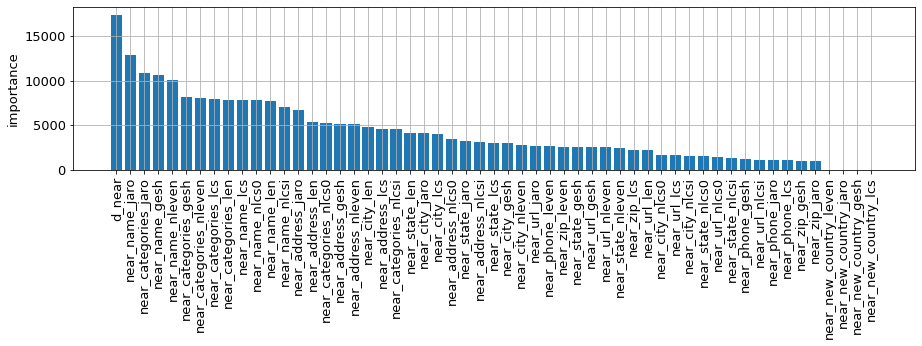

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 09:36:17,965] A new study created in memory with name: no-name-dbbea617-6346-4824-9aa7-037e7999ea96


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:37:11,197] Trial 0 finished with value: 0.7894616100125605 and parameters: {'threshold': 0.9410329871544376}. Best is trial 0 with value: 0.7894616100125605.


CV: 0.789462, precision: 0.995994, recall: 0.792714


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:38:11,934] Trial 1 finished with value: 0.811650234557278 and parameters: {'threshold': 0.8664280365172788}. Best is trial 1 with value: 0.811650234557278.


CV: 0.811650, precision: 0.991662, recall: 0.818529


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:39:07,872] Trial 2 finished with value: 0.8018165808426909 and parameters: {'threshold': 0.9083505590190889}. Best is trial 1 with value: 0.811650234557278.


CV: 0.801817, precision: 0.994072, recall: 0.806673


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:40:06,758] Trial 3 finished with value: 0.8304961698349141 and parameters: {'threshold': 0.6689701741779392}. Best is trial 3 with value: 0.8304961698349141.


CV: 0.830496, precision: 0.978975, recall: 0.848230


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.825696, precision: 0.943854, recall: 0.873816


[I 2022-05-13 09:41:15,708] Trial 4 finished with value: 0.8256962311147512 and parameters: {'threshold': 0.34084405023980335}. Best is trial 3 with value: 0.8304961698349141.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:42:14,623] Trial 5 finished with value: 0.8312339045789784 and parameters: {'threshold': 0.6491816418939798}. Best is trial 5 with value: 0.8312339045789784.


CV: 0.831234, precision: 0.977529, recall: 0.850211


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:43:11,683] Trial 6 finished with value: 0.8235081497569885 and parameters: {'threshold': 0.7765352386990703}. Best is trial 5 with value: 0.8312339045789784.


CV: 0.823508, precision: 0.986265, recall: 0.834971


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.830138, precision: 0.979626, recall: 0.847305


[I 2022-05-13 09:44:11,602] Trial 7 finished with value: 0.8301379024879558 and parameters: {'threshold': 0.6778917478387024}. Best is trial 5 with value: 0.8312339045789784.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:45:10,870] Trial 8 finished with value: 0.8080451853154723 and parameters: {'threshold': 0.8840518424583096}. Best is trial 5 with value: 0.8312339045789784.


CV: 0.808045, precision: 0.992662, recall: 0.814080


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:46:21,185] Trial 9 finished with value: 0.8145743532339842 and parameters: {'threshold': 0.24195882108989952}. Best is trial 5 with value: 0.8312339045789784.


CV: 0.814574, precision: 0.923728, recall: 0.879961


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:47:45,380] Trial 10 finished with value: 0.7362375721101266 and parameters: {'threshold': 0.05617825413183564}. Best is trial 5 with value: 0.8312339045789784.


CV: 0.736238, precision: 0.815078, recall: 0.893300


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832805, precision: 0.970652, recall: 0.857716


[I 2022-05-13 09:48:49,371] Trial 11 finished with value: 0.8328048217507921 and parameters: {'threshold': 0.5671716733370213}. Best is trial 11 with value: 0.8328048217507921.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:49:52,374] Trial 12 finished with value: 0.8319754298156757 and parameters: {'threshold': 0.47604826847621023}. Best is trial 11 with value: 0.8328048217507921.


CV: 0.831975, precision: 0.961571, recall: 0.864790


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.830774, precision: 0.956657, recall: 0.867830


[I 2022-05-13 09:50:57,840] Trial 13 finished with value: 0.8307743152766602 and parameters: {'threshold': 0.4330530915521933}. Best is trial 11 with value: 0.8328048217507921.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832825, precision: 0.968110, recall: 0.859952


[I 2022-05-13 09:52:00,485] Trial 14 finished with value: 0.8328254494534103 and parameters: {'threshold': 0.5400332168998232}. Best is trial 14 with value: 0.8328254494534103.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:53:02,790] Trial 15 finished with value: 0.8325131596352521 and parameters: {'threshold': 0.5954392635893778}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.832513, precision: 0.973135, recall: 0.855288


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:54:13,737] Trial 16 finished with value: 0.8136821691238495 and parameters: {'threshold': 0.23619675923903416}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.813682, precision: 0.922241, recall: 0.880339


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:55:16,495] Trial 17 finished with value: 0.8328221507215493 and parameters: {'threshold': 0.5407610939503681}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.832822, precision: 0.968173, recall: 0.859894


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:56:22,530] Trial 18 finished with value: 0.8292983920996921 and parameters: {'threshold': 0.39792577167396787}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.829298, precision: 0.952211, recall: 0.870185


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:57:29,584] Trial 19 finished with value: 0.8228539855286704 and parameters: {'threshold': 0.30855059412801156}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.822854, precision: 0.938229, recall: 0.875801


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:58:27,449] Trial 20 finished with value: 0.8236109951121492 and parameters: {'threshold': 0.7753616940037147}. Best is trial 14 with value: 0.8328254494534103.


CV: 0.823611, precision: 0.986186, recall: 0.835142


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 09:59:31,713] Trial 21 finished with value: 0.8328648073372364 and parameters: {'threshold': 0.559661471899497}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832865, precision: 0.969985, recall: 0.858360


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:00:35,414] Trial 22 finished with value: 0.8327106493572957 and parameters: {'threshold': 0.526228322671324}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832711, precision: 0.966769, recall: 0.861000


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:01:33,477] Trial 23 finished with value: 0.8250000085231656 and parameters: {'threshold': 0.7597810842702923}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.825000, precision: 0.985201, recall: 0.837372


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832624, precision: 0.965461, recall: 0.862043


[I 2022-05-13 10:02:37,273] Trial 24 finished with value: 0.8326237123606963 and parameters: {'threshold': 0.5127949914554895}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:03:38,911] Trial 25 finished with value: 0.8320636148864855 and parameters: {'threshold': 0.6224378419709146}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832064, precision: 0.975462, recall: 0.852824


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.830793, precision: 0.956714, recall: 0.867801


[I 2022-05-13 10:04:45,061] Trial 26 finished with value: 0.8307934511184822 and parameters: {'threshold': 0.43348571147052545}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.769919, precision: 0.859345, recall: 0.889906


[I 2022-05-13 10:06:04,005] Trial 27 finished with value: 0.7699193181126304 and parameters: {'threshold': 0.09620081880446213}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:07:02,828] Trial 28 finished with value: 0.8281685747655207 and parameters: {'threshold': 0.715456222269983}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.828169, precision: 0.982278, recall: 0.843058


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:08:09,221] Trial 29 finished with value: 0.8264051397197967 and parameters: {'threshold': 0.3501890233189363}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.826405, precision: 0.945333, recall: 0.873257


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:09:12,087] Trial 30 finished with value: 0.8327954314006759 and parameters: {'threshold': 0.5680095572288282}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832795, precision: 0.970727, recall: 0.857641


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:10:13,193] Trial 31 finished with value: 0.8328052156712974 and parameters: {'threshold': 0.56715468924635}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832805, precision: 0.970651, recall: 0.857717


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832333, precision: 0.963461, recall: 0.863505


[I 2022-05-13 10:11:18,434] Trial 32 finished with value: 0.8323329490533803 and parameters: {'threshold': 0.4937735333703929}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:12:06,683] Trial 33 finished with value: 0.7612138902745896 and parameters: {'threshold': 0.9777095156587408}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.761214, precision: 0.998377, recall: 0.762520


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832794, precision: 0.971024, recall: 0.857391


[I 2022-05-13 10:13:08,651] Trial 34 finished with value: 0.8327941538565222 and parameters: {'threshold': 0.5711327026261532}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:14:08,690] Trial 35 finished with value: 0.8293670207738626 and parameters: {'threshold': 0.6937636089649157}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.829367, precision: 0.980771, recall: 0.845559


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:15:14,306] Trial 36 finished with value: 0.8313678973254862 and parameters: {'threshold': 0.45008016069474366}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831368, precision: 0.958691, recall: 0.866667


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:16:10,757] Trial 37 finished with value: 0.8185534821768515 and parameters: {'threshold': 0.8226490771250432}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.818553, precision: 0.989089, recall: 0.827617


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.828604, precision: 0.950528, recall: 0.870953


[I 2022-05-13 10:17:17,926] Trial 38 finished with value: 0.8286041920185977 and parameters: {'threshold': 0.38548245940896303}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.831731, precision: 0.976327, recall: 0.851735


[I 2022-05-13 10:18:17,686] Trial 39 finished with value: 0.8317314434936045 and parameters: {'threshold': 0.633554883695829}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:19:20,472] Trial 40 finished with value: 0.8327013722290363 and parameters: {'threshold': 0.5242574964159691}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832701, precision: 0.966582, recall: 0.861150


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832859, precision: 0.970037, recall: 0.858305


[I 2022-05-13 10:20:22,694] Trial 41 finished with value: 0.8328589057055066 and parameters: {'threshold': 0.560293288172181}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:21:24,299] Trial 42 finished with value: 0.8321819050962133 and parameters: {'threshold': 0.6161526495418738}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832182, precision: 0.974928, recall: 0.853394


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:22:23,756] Trial 43 finished with value: 0.8278983932738097 and parameters: {'threshold': 0.7196431437254147}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.827898, precision: 0.982535, recall: 0.842566


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:23:26,846] Trial 44 finished with value: 0.8327432265750346 and parameters: {'threshold': 0.5327730274867665}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832743, precision: 0.967418, recall: 0.860479


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.830651, precision: 0.978789, recall: 0.848541


[I 2022-05-13 10:24:26,572] Trial 45 finished with value: 0.8306508158860201 and parameters: {'threshold': 0.6660493416161488}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:25:32,456] Trial 46 finished with value: 0.8320319033069234 and parameters: {'threshold': 0.47862377862502764}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832032, precision: 0.961845, recall: 0.864610


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832711, precision: 0.971763, recall: 0.856667


[I 2022-05-13 10:26:34,048] Trial 47 finished with value: 0.8327109855453607 and parameters: {'threshold': 0.5794784165151063}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:27:39,176] Trial 48 finished with value: 0.8291349885958024 and parameters: {'threshold': 0.39512270040545727}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.829135, precision: 0.951833, recall: 0.870351


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:28:38,081] Trial 49 finished with value: 0.8309958610955661 and parameters: {'threshold': 0.6561933594441836}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.830996, precision: 0.978044, recall: 0.849525


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.823352, precision: 0.939155, recall: 0.875507


[I 2022-05-13 10:29:46,488] Trial 50 finished with value: 0.8233522349110656 and parameters: {'threshold': 0.3134664452978795}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:30:49,944] Trial 51 finished with value: 0.8328373431487022 and parameters: {'threshold': 0.5473857777517461}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832837, precision: 0.968810, recall: 0.859361


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:31:53,358] Trial 52 finished with value: 0.8328394606767674 and parameters: {'threshold': 0.548595420421131}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832839, precision: 0.968932, recall: 0.859255


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:32:58,092] Trial 53 finished with value: 0.8316336273762662 and parameters: {'threshold': 0.46085278053323125}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831634, precision: 0.959877, recall: 0.865910


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:33:59,439] Trial 54 finished with value: 0.8327498138615888 and parameters: {'threshold': 0.533993004727847}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832750, precision: 0.967525, recall: 0.860391


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832304, precision: 0.974276, recall: 0.854080


[I 2022-05-13 10:35:01,507] Trial 55 finished with value: 0.8323036307159493 and parameters: {'threshold': 0.6086357486544488}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:36:05,294] Trial 56 finished with value: 0.832556015150942 and parameters: {'threshold': 0.5067715230091012}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832556, precision: 0.964824, recall: 0.862540


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:37:10,418] Trial 57 finished with value: 0.8306547203671905 and parameters: {'threshold': 0.42938367761053176}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.830655, precision: 0.956219, recall: 0.868084


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:38:08,589] Trial 58 finished with value: 0.8262914486966568 and parameters: {'threshold': 0.7437316926139368}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.826291, precision: 0.984135, recall: 0.839575


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:39:10,260] Trial 59 finished with value: 0.8313891921808632 and parameters: {'threshold': 0.6449362635575844}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831389, precision: 0.977221, recall: 0.850630


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:40:11,901] Trial 60 finished with value: 0.832841052267691 and parameters: {'threshold': 0.5469735108828692}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832841, precision: 0.968775, recall: 0.859392


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832863, precision: 0.968586, recall: 0.859579


[I 2022-05-13 10:41:13,644] Trial 61 finished with value: 0.8328629044121169 and parameters: {'threshold': 0.5448335094955821}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:42:14,702] Trial 62 finished with value: 0.8325187662577007 and parameters: {'threshold': 0.5938587119882427}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832519, precision: 0.972993, recall: 0.855416


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832136, precision: 0.962428, recall: 0.864200


[I 2022-05-13 10:43:18,603] Trial 63 finished with value: 0.8321358822951214 and parameters: {'threshold': 0.48417238371987076}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:44:20,429] Trial 64 finished with value: 0.8328599235464834 and parameters: {'threshold': 0.5575530271841913}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832860, precision: 0.969787, recall: 0.858531


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:45:24,193] Trial 65 finished with value: 0.8328429829707074 and parameters: {'threshold': 0.5545479549305001}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832843, precision: 0.969489, recall: 0.858774


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:46:25,774] Trial 66 finished with value: 0.8321826236629654 and parameters: {'threshold': 0.6157191391918727}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832183, precision: 0.974888, recall: 0.853432


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:47:24,948] Trial 67 finished with value: 0.8298489147140705 and parameters: {'threshold': 0.6835369950368141}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.829849, precision: 0.980020, recall: 0.846676


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.830436, precision: 0.955460, recall: 0.868513


[I 2022-05-13 10:48:28,498] Trial 68 finished with value: 0.8304356640710565 and parameters: {'threshold': 0.42310947403906185}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832578, precision: 0.965035, recall: 0.862375


[I 2022-05-13 10:49:32,934] Trial 69 finished with value: 0.8325783531508275 and parameters: {'threshold': 0.5087180544946477}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.819858, precision: 0.988395, recall: 0.829509


[I 2022-05-13 10:50:30,193] Trial 70 finished with value: 0.8198576928011189 and parameters: {'threshold': 0.8113386841302144}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:51:33,455] Trial 71 finished with value: 0.8328414877542747 and parameters: {'threshold': 0.5632756655005384}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832841, precision: 0.970320, recall: 0.858035


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:52:34,449] Trial 72 finished with value: 0.8328551564527537 and parameters: {'threshold': 0.5587575123984083}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832855, precision: 0.969899, recall: 0.858426


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832569, precision: 0.972553, recall: 0.855851


[I 2022-05-13 10:53:37,101] Trial 73 finished with value: 0.8325685181408913 and parameters: {'threshold': 0.5888149633420415}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:54:37,968] Trial 74 finished with value: 0.8328617782057559 and parameters: {'threshold': 0.5586013692550055}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832862, precision: 0.969886, recall: 0.858445


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.831616, precision: 0.959797, recall: 0.865959


[I 2022-05-13 10:55:42,827] Trial 75 finished with value: 0.8316155430175073 and parameters: {'threshold': 0.46013980831672935}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:56:43,714] Trial 76 finished with value: 0.8315681834838227 and parameters: {'threshold': 0.6391149768085748}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831568, precision: 0.976757, recall: 0.851210


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832386, precision: 0.963637, recall: 0.863406


[I 2022-05-13 10:57:46,961] Trial 77 finished with value: 0.8323860673027098 and parameters: {'threshold': 0.49532257901014637}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832855, precision: 0.970029, recall: 0.858310


[I 2022-05-13 10:58:48,907] Trial 78 finished with value: 0.8328551816213329 and parameters: {'threshold': 0.5602079671471643}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832489, precision: 0.973268, recall: 0.855140


[I 2022-05-13 10:59:49,192] Trial 79 finished with value: 0.8324887860108188 and parameters: {'threshold': 0.5970925279760535}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.827851, precision: 0.948671, recall: 0.871820


[I 2022-05-13 11:00:57,204] Trial 80 finished with value: 0.8278514897147866 and parameters: {'threshold': 0.37263887713675115}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:01:59,851] Trial 81 finished with value: 0.8328534836951966 and parameters: {'threshold': 0.562388459276005}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832853, precision: 0.970240, recall: 0.858117


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:03:04,916] Trial 82 finished with value: 0.832655211406512 and parameters: {'threshold': 0.5160544262965074}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832655, precision: 0.965798, recall: 0.861783


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832807, precision: 0.970510, recall: 0.857841


[I 2022-05-13 11:04:06,778] Trial 83 finished with value: 0.8328073877023487 and parameters: {'threshold': 0.5656178534844858}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:05:09,042] Trial 84 finished with value: 0.8321041886687185 and parameters: {'threshold': 0.6205236043257567}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832104, precision: 0.975315, recall: 0.852986


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:06:08,797] Trial 85 finished with value: 0.8283091862637112 and parameters: {'threshold': 0.7127766653836318}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.828309, precision: 0.982073, recall: 0.843380


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832598, precision: 0.972299, recall: 0.856092


[I 2022-05-13 11:07:11,071] Trial 86 finished with value: 0.8325983165462771 and parameters: {'threshold': 0.5861212598834684}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:08:11,818] Trial 87 finished with value: 0.8306165879330148 and parameters: {'threshold': 0.6666495408496775}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.830617, precision: 0.978827, recall: 0.848474


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:09:14,547] Trial 88 finished with value: 0.8328409498855441 and parameters: {'threshold': 0.5521166462128058}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832841, precision: 0.969268, recall: 0.858966


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:10:18,362] Trial 89 finished with value: 0.831879527076622 and parameters: {'threshold': 0.4701425756611729}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831880, precision: 0.960945, recall: 0.865232


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:11:22,837] Trial 90 finished with value: 0.8326905560967707 and parameters: {'threshold': 0.5203063520327977}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832691, precision: 0.966216, recall: 0.861459


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832422, precision: 0.963938, recall: 0.863184


[I 2022-05-13 11:12:26,857] Trial 91 finished with value: 0.8324222361516523 and parameters: {'threshold': 0.49823896918948646}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:13:29,300] Trial 92 finished with value: 0.8328363331104977 and parameters: {'threshold': 0.5635630395418216}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832836, precision: 0.970348, recall: 0.858005


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.831625, precision: 0.976587, recall: 0.851412


[I 2022-05-13 11:14:28,771] Trial 93 finished with value: 0.8316254722743809 and parameters: {'threshold': 0.6369182645490937}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:15:31,762] Trial 94 finished with value: 0.8327411766332671 and parameters: {'threshold': 0.5766431815587146}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832741, precision: 0.971503, recall: 0.856922


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832341, precision: 0.974083, recall: 0.854286


[I 2022-05-13 11:16:33,056] Trial 95 finished with value: 0.8323413557518775 and parameters: {'threshold': 0.6064121300268027}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832789, precision: 0.967781, recall: 0.860205


[I 2022-05-13 11:17:37,249] Trial 96 finished with value: 0.8327890982916364 and parameters: {'threshold': 0.5365579087240163}. Best is trial 21 with value: 0.8328648073372364.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:18:50,004] Trial 97 finished with value: 0.8017654652528476 and parameters: {'threshold': 0.17817726013279667}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.801765, precision: 0.903977, recall: 0.884069


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:19:53,560] Trial 98 finished with value: 0.8313316807011081 and parameters: {'threshold': 0.44920801796959897}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.831332, precision: 0.958588, recall: 0.866720


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:20:58,374] Trial 99 finished with value: 0.8320484789369124 and parameters: {'threshold': 0.47962498503382667}. Best is trial 21 with value: 0.8328648073372364.


CV: 0.832048, precision: 0.961956, recall: 0.864529


In [ ]:
threshold = study.best_params['threshold']
threshold

0.559661471899497

In [ ]:
study.best_value

0.8328648073372364

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.832865, precision: 0.969985, recall: 0.858360


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
